# Comparing the norm of different state vectors

In [1]:
import torch as pt
import matplotlib.pyplot as plt
from flow_conditions import A_INF, CHORD

plt.rcParams['figure.dpi'] = 160
plt.rc('text', usetex=True)

output = "./output/naca0012_analysis/"
!mkdir -p $output

In [2]:
# surface pressure coefficient
data = "./output/naca0012_data/"
dm_cp = pt.load(f"{data}surface/dm_ref1_z25.pt")
times_cp = pt.load(f"{data}surface/times_ref1_z25.pt")
start_idx = (times_cp - 0.025).abs().argmin()
end_idx = (times_cp - 0.1385).abs().argmin()
dm_cp = dm_cp[:, start_idx:end_idx+1]
times_cp = times_cp[start_idx:end_idx+1]
times_cp = times_cp - times_cp[0]
dtimes = times_cp * A_INF / CHORD

In [3]:
# slice data
dm_slice = pt.load(f"{data}slice/dm_ref1_z25.pt")
w = pt.load(f"{data}slice/w_ref1_z25.pt").sqrt().unsqueeze(-1)
n_points = w.shape[0]
n_times = dm_slice.shape[-1]

In [4]:
U = (dm_slice[:n_points, :]**2 + dm_slice[n_points:2*n_points, :]**2 + dm_slice[2*n_points:3*n_points, :]**2).sqrt()
rho = dm_slice[3*n_points:4*n_points, :]
Ma = dm_slice[4*n_points:, :]
a = U / Ma
gamma = pt.tensor(1.4)
scale = pt.sqrt(2/(gamma*(gamma-1)))

cp min/max:  tensor(0.9660) tensor(1.4374) tensor(0.4714)
rho min/max:  tensor(0.9773) tensor(1.0219) tensor(0.0445)
w rho min/max:  tensor(0.9955) tensor(1.0082) tensor(0.0126)
w u_x, u_y min/max:  tensor(0.9966) tensor(1.0099) tensor(0.0133)
w u_x, u_y, u_z min/max:  tensor(0.9967) tensor(1.0100) tensor(0.0133)
w a min/max:  tensor(0.9982) tensor(1.0019) tensor(0.0037)
w a, u_x, u_y min/max:  tensor(0.9994) tensor(1.0021) tensor(0.0027)


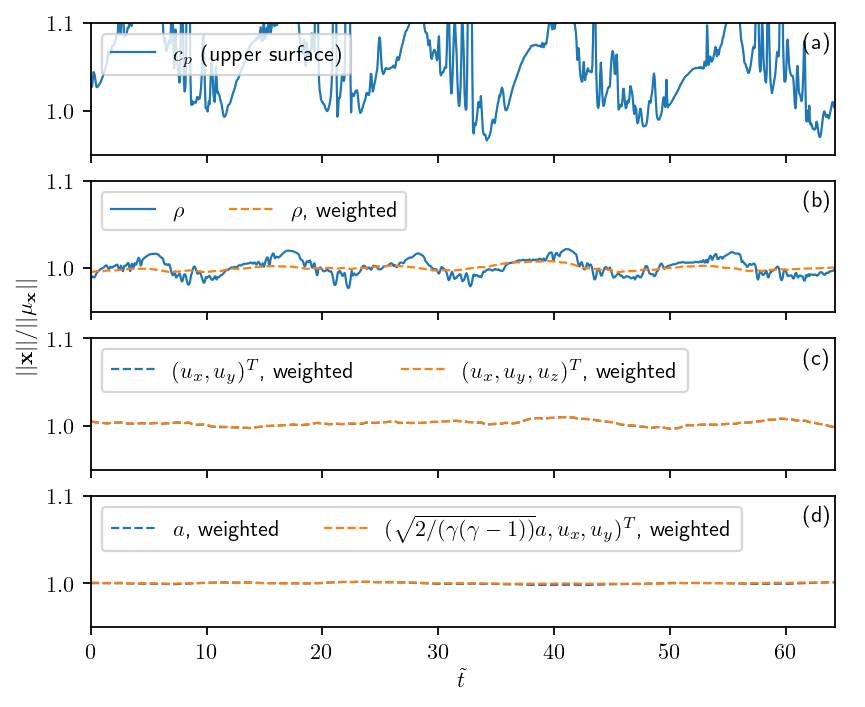

In [15]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(6, 5), sharex=True)

ymin, ymax = 0.95, 1.1
norm_over_time = dm_cp.norm(dim=0) / dm_cp.mean(dim=1).norm()
print("cp min/max: ", norm_over_time.min(), norm_over_time.max(), norm_over_time.max()-norm_over_time.min())
ax1.plot(dtimes, dm_cp.norm(dim=0) / dm_cp.mean(dim=1).norm(), lw=1, label=r"$c_p$ (upper surface)")
ax1.legend(loc="upper left")
ax1.set_ylim(ymin, ymax)
norm_over_time = rho.norm(dim=0) / rho.mean(dim=1).norm()
print("rho min/max: ", norm_over_time.min(), norm_over_time.max(), norm_over_time.max()-norm_over_time.min())
ax2.plot(dtimes, norm_over_time, lw=1, label=r"$\rho$")
norm_over_time = (rho*w).norm(dim=0) / (rho*w).mean(dim=1).norm()
print("w rho min/max: ", norm_over_time.min(), norm_over_time.max(), norm_over_time.max()-norm_over_time.min())
ax2.plot(dtimes, norm_over_time, ls="--", lw=1, label=r"$\rho$, weighted")
ax2.legend(ncol=2, loc="upper left")
ax2.set_ylim(ymin, ymax)
# skip non-weighted state vectors; results qualitatively similar to density
#dm_xy = dm_slice[:2*n_points, :]
#dm_xyz = dm_slice[:3*n_points, :]
#ax3.plot(dtimes, dm_xy.norm(dim=0) / dm_xy.mean(dim=1).norm(), c="C0", lw=1, label=r"$u_x$, $u_y$")
#ax3.plot(dtimes, dm_xyz.norm(dim=0) / dm_xyz.mean(dim=1).norm(), c="C1", lw=1, label=r"$u_x$, $u_y$, $u_z$")
dm_xyw = dm_slice[:2*n_points, :] * w.repeat((2, 1))
dm_xyzw = dm_slice[:3*n_points, :] * w.repeat((3, 1))
norm_over_time = dm_xyw.norm(dim=0) / dm_xyw.mean(dim=1).norm()
print("w u_x, u_y min/max: ", norm_over_time.min(), norm_over_time.max(), norm_over_time.max()-norm_over_time.min())
ax3.plot(dtimes, norm_over_time, ls="--", c="C0", lw=1, label=r"$(u_x, u_y)^T$, weighted")
norm_over_time = dm_xyzw.norm(dim=0) / dm_xyzw.mean(dim=1).norm()
print("w u_x, u_y, u_z min/max: ", norm_over_time.min(), norm_over_time.max(), norm_over_time.max()-norm_over_time.min())
ax3.plot(dtimes, norm_over_time, ls="--", c="C1", lw=1, label=r"$(u_x, u_y, u_z)^T$, weighted")
ax3.legend(ncol=2, loc="upper left")
ax3.set_ylim(ymin, ymax)
# no major difference when weighted with density
#ax3.plot(dtimes, (dm_xyw * rho.sqrt().repeat((2, 1))).norm(dim=0) / (dm_xyw *rho.sqrt().repeat((2, 1))).mean(dim=1).norm(), ls=":", c="C0", lw=1, label=r"$w\rho u_x$, $wu_y$")
dm_xyaw = pt.zeros((3*n_points, n_times))
dm_xyaw[:2*n_points, :] = dm_slice[:2*n_points, :] * w.repeat((2, 1))
dm_xyaw[2*n_points:, :] = scale * a * w
norm_over_time = (scale*a*w).norm(dim=0) / (scale*a*w).mean(dim=1).norm()
print("w a min/max: ", norm_over_time.min(), norm_over_time.max(), norm_over_time.max()-norm_over_time.min())
ax4.plot(dtimes, norm_over_time, ls="--", lw=1, label=r"$a$, weighted")
norm_over_time = dm_xyaw.norm(dim=0) / dm_xyaw.mean(dim=1).norm()
print("w a, u_x, u_y min/max: ", norm_over_time.min(), norm_over_time.max(), norm_over_time.max()-norm_over_time.min())
ax4.plot(dtimes, norm_over_time, ls="--", lw=1, label=r"$(\sqrt{2/(\gamma (\gamma -1))} a, u_x, u_y)^T$, weighted")
ax4.legend(ncol=2, loc="upper left")
ax4.set_ylim(ymin, ymax)

for ax, label in zip((ax1, ax2, ax3, ax4), ("(a)", "(b)", "(c)", "(d)")):
    ax.text(61.5, 1.07, s=label)

fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.ylabel(r"$||\mathbf{x}|| / || \mu_\mathbf{x}||$")
ax4.set_xlabel(r"$\tilde{t}$")
ax4.set_xlim(dtimes[0], dtimes[-1])

plt.savefig(f"{output}state_norm.pdf", bbox_inches="tight")
plt.savefig(f"{output}state_norm.svg", bbox_inches="tight")
plt.savefig(f"{output}state_norm.png", bbox_inches="tight")

plt.show()